In [178]:
words = open('names-shuffled.txt', 'r').read().splitlines()

In [179]:
words[:10]

['pushp',
 'aishwary',
 'prahalan',
 'adrija',
 'ghanika',
 'vibulan',
 'kavinthran',
 'priyaalen',
 'sutharman',
 'radikaa']

In [180]:
min(len(w) for w in words)

2

In [181]:
max(len(w) for w in words)

24

In [182]:
set(''.join(words)).__len__()

26

### Bigram ###

In [183]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs, chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

In [184]:
sorted(b.items(), key = lambda kv : kv[1], reverse= True)[:10]

[(('a', 'n'), 26410),
 (('h', 'a'), 18636),
 (('a', '<E>'), 16717),
 (('t', 'h'), 15411),
 (('s', 'h'), 14664),
 (('n', '<E>'), 13778),
 (('a', 'r'), 11221),
 (('r', 'a'), 10972),
 (('i', '<E>'), 9144),
 (('h', 'i'), 8360)]

In [185]:
import torch

In [186]:
N = torch.zeros((27, 27), dtype=torch.int32)

In [187]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
# stoi['<S>'] = 26
# stoi['<E>'] = 27
stoi['.'] = 0
itos = {v:k for k, v in stoi.items()}

In [188]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        N[ix1, ix2] += 1

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 26.5, 26.5, -0.5)

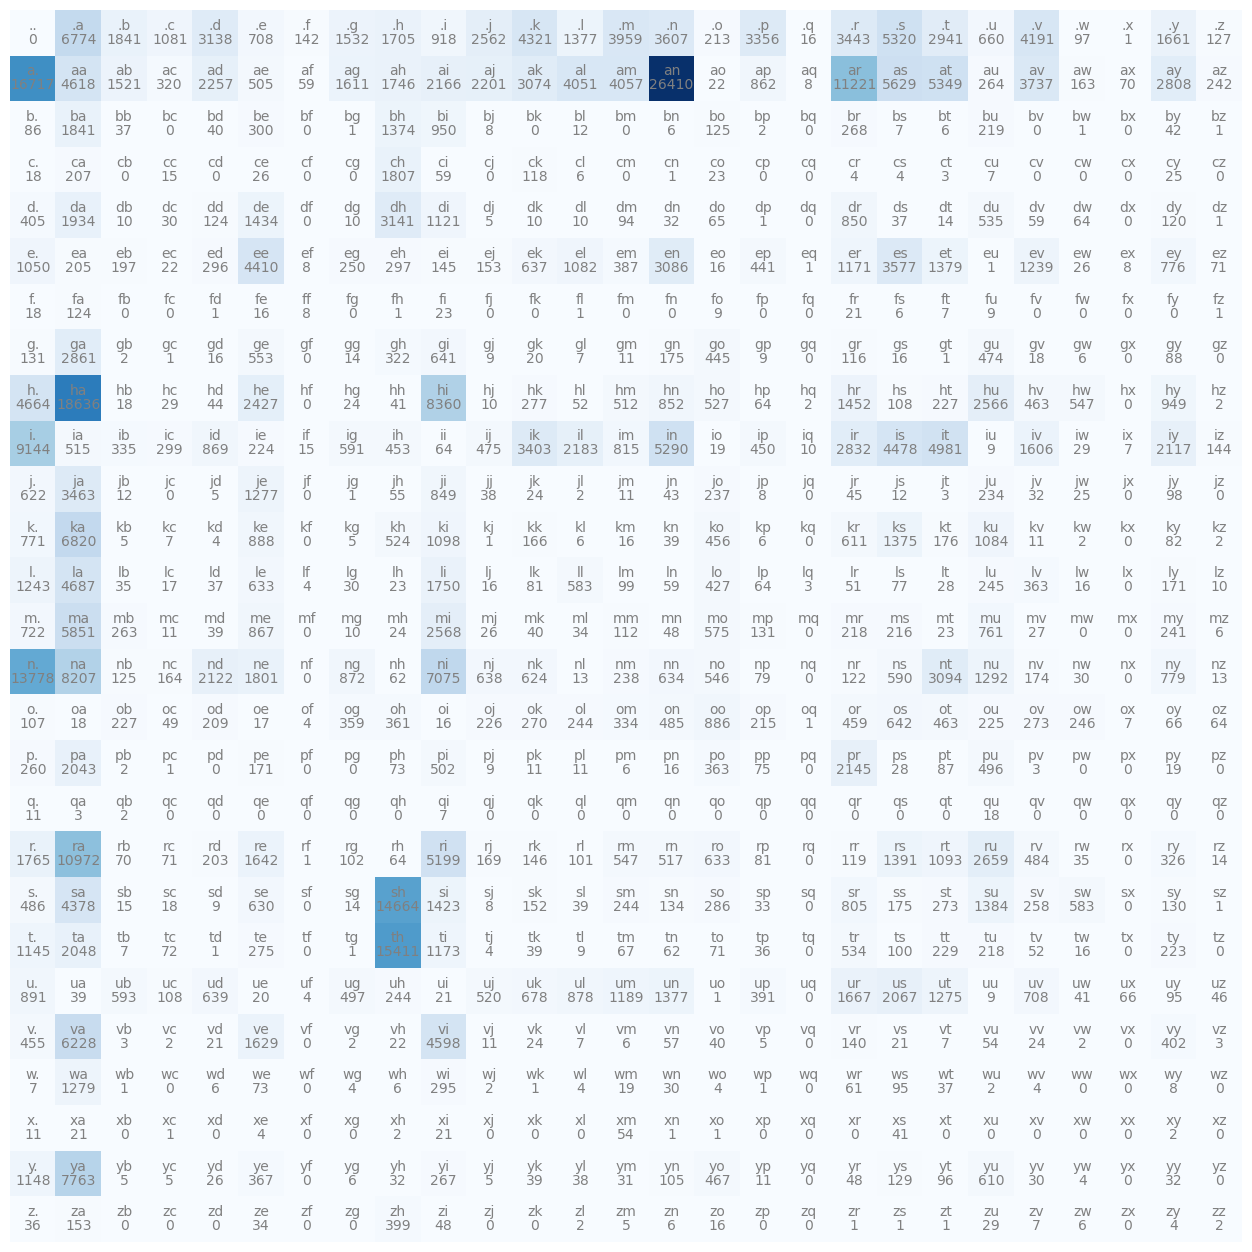

In [190]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis('off')

In [191]:
g = torch.Generator().manual_seed(1337101)
p = torch.rand(3, generator=g)
p = p/p.sum()
p

tensor([0.2494, 0.0738, 0.6769])

**Multinomial** - you give me prob, I'll give you integers which are sampled according to that probability distribution

In [192]:
g = torch.Generator().manual_seed(1337101)
# we're giving it a prob distribution p, and this is giving us indexes according to that prob distribution
torch.multinomial(p, num_samples=10, replacement=True, generator=g)

# notice that the prob of 2nd index is the highest, so it is occuring the highest number of times in the result

tensor([2, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [193]:
g = torch.Generator().manual_seed(1337101)
p = N[0].float()
p = p/p.sum()
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
itos[ix.item()]

'm'

In [194]:
# N cotains the frequency of occurance of bigrams
P = N.float() # this will store all the probabilities (normalized N)

# dim=1 means sum elements across the rows (left to right) or squeeze columns
# keepdim=True will ensure the output tensor will have same number of dimensions as input
P /= P.sum(dim=1, keepdim=True)

# P.sum(dim=1, keepdim=True).shape - this will output tensor of shape [27, 1] - column vector

# P.sum(dim=1).shape               - this will output tensor of shape [27] 
# when broadcasting while dividing, it will become [1, 27] - row vector and will give incorrect result when dividing

# Read Broadcasting Semantics - https://pytorch.org/docs/stable/notes/broadcasting.html


In [195]:
g = torch.Generator().manual_seed(1337101)

for i in range(5):
    out = []
    ix = 0 # starting character
    while True:
        # p = N[ix].float() # take out the row corrosponding to the character (it contains the occurance count)
        # p = p/p.sum() # normalize it (just calulating probabilities of occurance)

        # for efficiency, using 'P' rather than 'N'
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # draw one sample
        out.append(itos[ix])
        if ix == 0: # if the character is "." means it's the last character
            break
    print(''.join(out))

mkus.
kshivanialaeesthan.
nde.
th.
kasagen.


### Negative Log Likelihood

The **likelihood** helps in evaluating how well the model fits the observed data.

**High Likelihood:** If the matrix P assigns high probabilites to bigrams that **actually occur in the data**, the overall likelihood will be high, meaning the model fits the data well.

Suppose you are modeling bigram character transitions. The transition matrix P contains the probabilities of transitioning from one character to another (e.g., from 'h' to 'e'). Here's how the likelihood helps you evaluate the model:

Example Data: Let’s say you observe the following transitions in a word:

['h', 'e'], ['e', 'l'], ['l', 'l'], ['l', 'o']

Example Transition Matrix: If the model predicts that the probability of transitioning from 'h' to 'e' is 0.8, from 'e' to 'l' is 0.7, and so on, then the likelihood of the entire sequence is:

L = P['h', 'e'] x P['e', 'l'] x P['l', 'l'] x P['l', 'o']

If the model assigns high probabilities to all of these transitions, the product will be close to 1, indicating that the model fits this sequence well. If any of these probabilities are low, the product will be small, indicating a poor fit.

**Log-Likelihood**

Since multiplying probabilities can lead to very small numbers, we use the log-likelihood instead of the direct likelihood to avoid underflow and make the computation easier.

If the transition probabilities are high, the log-likelihood will be less negative (closer to 0), indicating a better model fit.

If the transition probabilities are low, the log-likelihood will be more negative, indicating a poor fit.


In [196]:
log_likelihood = 0.0
n = 0.0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]

        prob = P[ix1, ix2]
        log_prob = torch.log(prob)

        log_likelihood += log_prob
        n += 1

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-1103390.5000)
nll=tensor(1103390.5000)
2.1829562187194824


**NLL**: The lower this number is, better the model is because it is high giving high probability to **actual** characters.

**Model Smoothning**

For some of the pairs, like 'jx' the probability is 0, which can make the log_likelihood infinity. So, we can add 1 to all the occurance counts. This is also called model smoothning.

In [197]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

In [198]:
# creating the traning set of bigrams (x, y)

# here, the input 'xs' is the first character of bigram and 'ys' is the second character, the prediction/label
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        print(c1, c2)
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

# for xs[i], ys[i] should be the next character

. p
p u
u s
s h
h p
p .


In [199]:
xs

tensor([ 0, 16, 21, 19,  8, 16])

In [200]:
ys

tensor([16, 21, 19,  8, 16,  0])

In [201]:
import torch.nn.functional as F

In [202]:
xenc = F.one_hot(xs, num_classes=27).float() # floats are good to feed into neural networks
xenc.shape

torch.Size([6, 27])

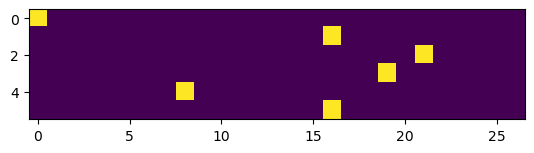

In [203]:
plt.imshow(xenc)

One example is a character e.g. in 'hello' it is 'h' and the size of the one-hot encoding for this will be [1, 27]. Output is 'e' and its size is also [1, 27].

In the input layer there will be 27 inputs. These inputs will be sent to a neuron. When these 27 inputs arrive at the neuron the input will be a row vector of size [1, 27] (one element coming from each input). The neuron will be having a weight wi of dimension [27, 1]. When we multiply the input with weight wi -> [1, 27] @ [27, 1] = [1, 1]

Now, we'll take 27 such neurons and each will have weight of size [27, 1].

If we combine all these Ws (w1, w2, w3, ..., w27) we will have a metrix W of size [27, 27].

So, final output size will be input @ W -> [1, 27] @ [27, 27] = [1, 27]

In [204]:
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [205]:
W = torch.randn((27, 27))
W

tensor([[-1.4254e+00, -1.5463e-01,  6.7708e-01,  2.9951e-01,  6.6186e-01,
         -1.9438e+00, -9.2821e-01,  1.7585e-01, -1.1954e+00,  7.3447e-01,
         -9.1446e-01, -5.6258e-01,  5.1893e-01, -1.8654e+00,  2.3436e-01,
          1.0065e+00, -5.2688e-01,  3.7043e-01,  7.2938e-01, -1.1532e+00,
         -1.1993e+00,  5.6261e-01,  1.5673e+00, -1.8655e-01,  3.3365e-02,
          3.4791e-01,  1.0519e+00],
        [-1.6322e+00,  3.8371e-01,  4.9590e-02, -1.2209e+00, -2.3119e-01,
          3.9210e-01,  7.9058e-01, -1.0099e+00,  2.5570e-01,  2.4506e-01,
          9.3209e-01,  7.3305e-03, -3.7820e-01,  1.0559e+00, -2.6436e-01,
         -1.3568e+00, -1.3934e+00, -8.1747e-01,  1.5546e+00,  9.7623e-01,
         -1.5814e+00,  3.1553e-01, -2.8266e-01, -1.1819e+00, -1.0026e+00,
         -1.5698e+00,  4.1499e-01],
        [ 1.5103e+00,  3.4080e-01,  5.2866e-01,  4.8730e-01, -6.3868e-01,
          4.1760e-02, -3.4519e-01, -6.2520e-01, -6.8624e-01, -9.6289e-01,
          3.1887e-01, -5.7332e-01,  9.01

In [206]:
(xenc @ W)[:,0 ]

tensor([-1.4254,  0.8852, -1.1609,  0.4636,  0.6024,  0.8852])

Each row in xenc is an input to the model. Each input is of size [1, 27] (row vector) which will be multiplied with the weights of 27 neurons having weights wi of size [27, 1] (column vector) and produce an output of size [1, 1] (for a single neuron). If we combine all these weights of 27 neurons in a single metrix W of size [27, 27] (resulted from combining all 27 weight column metrices) and multiply the input row vector of size [1, 27] with W of size [27, 27] we will get an output of size [1, 27].

If we now look at complete xenc metrix it will be of size [m, 27] (where m is the length of the word + 1) and multiply it by W of size [27, 27] we will get the output of size [m, 27].

In this output metrix of size [m, 27]:
- The row at [i, :] is the activation of all neurons because of the ith character in the word.
- The element at [i, j] is the activation of jth neuron because of the ith character in the word.
- The column at [:, j] is the activations of jth neuron because of all the characters in the word.

In [207]:
(xenc @ W)

tensor([[-1.4254, -0.1546,  0.6771,  0.2995,  0.6619, -1.9438, -0.9282,  0.1759,
         -1.1954,  0.7345, -0.9145, -0.5626,  0.5189, -1.8654,  0.2344,  1.0065,
         -0.5269,  0.3704,  0.7294, -1.1532, -1.1993,  0.5626,  1.5673, -0.1866,
          0.0334,  0.3479,  1.0519],
        [ 0.8852, -0.5972, -0.6339,  0.8291, -0.5722,  0.0828, -1.2857,  0.8377,
          1.0355, -0.0483,  0.0422, -0.2747,  0.8026, -0.1379, -0.8643, -0.6807,
          2.2110,  1.0898,  0.4664,  2.2160,  0.8177,  0.4157, -0.1248, -0.2191,
          0.4726,  0.5102, -1.3243],
        [-1.1609, -0.9597,  0.6199, -0.0893, -0.3757,  0.9023, -0.5531,  0.5554,
          0.4986, -0.6554,  0.0334, -1.8134, -0.1273, -1.0944, -1.3466,  0.0604,
         -0.9981, -0.1800,  0.4714, -1.4600, -0.4184, -0.5535,  0.2233,  0.2883,
         -1.1210, -0.6977,  0.4682],
        [ 0.4636, -0.9106,  0.1445, -1.0282, -0.3669,  0.5044, -0.3466, -0.4963,
         -1.0975,  0.0899,  2.3596,  1.0699,  1.6215,  0.8815, -2.0627,  0.5108

### Logits

**How do we interpret the output?**

We have the output of size [1, 27] for an input of size [1, 27]. These 27 output numbers are positive and negative. We want to interpret these numbers as log counts because ultimately we want to calculate the probability of these 27 numbers being the next charater for the input character.

NOTE: The 27 in input is the one-hot encoding of a single character but in the output it is not one-hot encoding, these are some positive and negative numbers.

We will interpret the output numbers as log counts and exponentiate them. All the -ve numbers become numbers between 0 and 1 and all +ve numbers will be greater than 1.

These log counts are called as logits.

The exponentiated logits will be equivalent to N metrix which contains the occurance counts.

In [208]:
import numpy as np

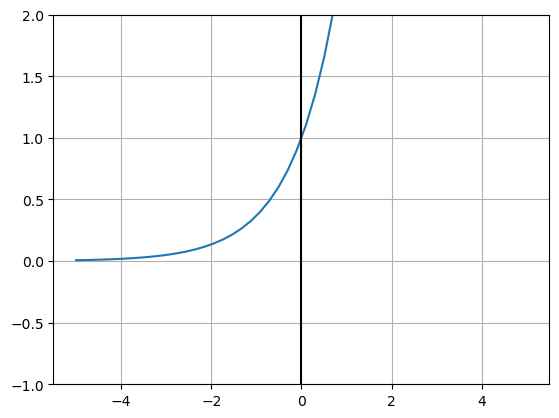

In [209]:
xin = np.linspace(-5, 5)
plt.plot(xin, np.exp(xin))
plt.grid(True, which='both')
plt.ylim([-1,2])
plt.axvline(x=0, color='k')
plt.show()

In [210]:
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent to N
probs = counts/counts.sum(dim=1, keepdim=True) # equivalent to P

# The last 2 lines are together called as 'Softmax'

probs

tensor([[0.0069, 0.0247, 0.0567, 0.0389, 0.0559, 0.0041, 0.0114, 0.0344, 0.0087,
         0.0601, 0.0115, 0.0164, 0.0484, 0.0045, 0.0364, 0.0789, 0.0170, 0.0417,
         0.0598, 0.0091, 0.0087, 0.0506, 0.1382, 0.0239, 0.0298, 0.0408, 0.0825],
        [0.0471, 0.0107, 0.0103, 0.0445, 0.0110, 0.0211, 0.0054, 0.0449, 0.0547,
         0.0185, 0.0203, 0.0148, 0.0433, 0.0169, 0.0082, 0.0098, 0.1772, 0.0577,
         0.0310, 0.1781, 0.0440, 0.0294, 0.0171, 0.0156, 0.0311, 0.0323, 0.0052],
        [0.0130, 0.0159, 0.0771, 0.0379, 0.0285, 0.1022, 0.0239, 0.0723, 0.0683,
         0.0215, 0.0429, 0.0068, 0.0365, 0.0139, 0.0108, 0.0440, 0.0153, 0.0346,
         0.0664, 0.0096, 0.0273, 0.0238, 0.0518, 0.0553, 0.0135, 0.0206, 0.0662],
        [0.0354, 0.0090, 0.0257, 0.0080, 0.0154, 0.0369, 0.0157, 0.0135, 0.0074,
         0.0243, 0.2356, 0.0649, 0.1126, 0.0537, 0.0028, 0.0371, 0.1250, 0.0036,
         0.0100, 0.0102, 0.0152, 0.0295, 0.0164, 0.0020, 0.0073, 0.0376, 0.0452],
        [0.0438, 0.0108,

In [211]:
probs[0].sum()

tensor(1.)

For every example in a word a row comes out from the model which gives the probability for next character.

Summarizing above steps -------------------------->

In [212]:
xs

tensor([ 0, 16, 21, 19,  8, 16])

In [213]:
ys

tensor([16, 21, 19,  8, 16,  0])

In [214]:
# initialize weight matrix
g = torch.Generator().manual_seed(1337101)
W = torch.randn((27, 27), generator=g)

In [215]:
xenc = F.one_hot(xs, num_classes=27).float() # input to model
logits = xenc @ W # predicted log counts
counts = logits.exp() # counts
probs = counts / counts.sum(dim=1, keepdim=True) # prob of next character
# last 2 lines together are called 'Softmax'

In [216]:
probs.shape

torch.Size([6, 27])

In [217]:
nlls = torch.zeros(6)

for i in range(6):
    x = xs[i].item() # input character index
    y = ys[i].item() # output character index

    print('-----------')

    print(f'Bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print('Input to NN: ', xenc[i])
    print('Output probabilities from NN: ', probs[i])
    print('Label (actual next character): ', y)
    p = probs[i][y]
    print(f'Prob assigned by NN to character number {y}: {p.item()}')
    logp = torch.log(p)
    print('Log Likelihood: ', logp.item())
    nll = - logp
    print('Log Likelihood: ', nll.item())
    nlls[i] = nll
print('===========')
print('Average nll i.e. loss: ', torch.mean(nlls).item())


-----------
Bigram example 1: .p (indexes 0, 16)
Input to NN:  tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
Output probabilities from NN:  tensor([0.0340, 0.0140, 0.4034, 0.0054, 0.0155, 0.0089, 0.0023, 0.0191, 0.0323,
        0.0262, 0.0225, 0.0352, 0.0024, 0.0301, 0.0218, 0.0017, 0.0328, 0.0066,
        0.0021, 0.0516, 0.0636, 0.0066, 0.0019, 0.0076, 0.0007, 0.0269, 0.1245])
Label (actual next character):  16
Prob assigned by NN to character number 16: 0.03284802660346031
Log Likelihood:  -3.415863513946533
Log Likelihood:  3.415863513946533
-----------
Bigram example 2: pu (indexes 16, 21)
Input to NN:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
Output probabilities from NN:  tensor([0.0898, 0.0030, 0.0041, 0.0181, 0.0337, 0.0734, 0.0039, 0.0310, 0.0150,
        0.0362, 0.0153, 0.0057, 0.1156, 0.0193, 0.0062, 0.0053, 0.0260

In [218]:
nlls.mean()

tensor(3.9727)

In above what we're doing is out of the output probs matrix finding out the prob of the correct next character.

Probs is of shape [i, 27], each row contains a list of prob of being the next character to the ith character.

After that we're taking the log of prob and finding out the nll

Rather than doing it in multiple steps, we can do it lesser steps as follows.

In [219]:
# torch.arange(6) will provide the row index, like 0, 1, 2, 3, 4, 5
# ys will provide the index to find out the prob of actual character
# these 2 steps are equivalent to p = probs[i][y] in the above loop
loss = - probs[torch.arange(6), ys].log().mean()
loss
# this is same as above

tensor(3.9727)

------------ OPTIMIZATION -----------------

In [220]:
g = torch.Generator().manual_seed(1337101)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [221]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to model
logits = xenc @ W # predicted log counts
counts = logits.exp() # counts
probs = counts / counts.sum(dim=1, keepdim=True)

In [222]:
# calculate loss
loss = - probs[torch.arange(6), ys].log().mean()

In [223]:
loss.item()

3.972670555114746

In [224]:
# zero grad
W.grad = None # this is more efficient than running a loop on all params and setting grads as zero

In [225]:
# backpropagation
loss.backward()

In [226]:
# update the weights on the basis of updated grads
W.data += - 0.1*W.grad

Now if we re-run the forward pass the loss will decrease.

## Final Code Summarization

In [246]:
# create the dataset

xs, ys = [], []

for w in words: #[:1]: running over all the words
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.numel()

print('Number of examples: ', num)

# initialize the 'network'

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)


Number of examples:  505457


Model Smoothning Alternative

- We added some number to smoothen N previously (N+1). If add like a million to all the occurences in N then the probabilities will be uniform. The distribution of probabilities will be uniform.
- If all the entries in W are 0, logits will be all 0, counts will become all 1 because of exp and prob will be exactly uniform, all probabilities will be equal.
- So trying to make all entries in W closer to 0 is equivalent to model smoothening.
- We can think of it in a way like, if entries in W are non-zero then it is loss for us and we want to reduce this loss like NLL.
- One way to calculate this non-zero entries loss is to square the W matrix and calculate the mean. Squaring will make all the values positive. Higher the non-zero values, higher will be the mean and higher will be the loss.
- We will add this loss to NLL. Loss = NLL + alpha * (W**2).mean() where alpha is some multiplier controlling the strength of this loss.
- Now this optimization has 2 components. Not only this is trying to optimize all the probabilities in addition to that there's more component which is trying to make all the W's be zero. So, now all the W's want to be zero and all the probabilites want to be uniform but they also simultaneously optimize the probabilities.
- If alpha is very high, like 1, they force of alpha * (W**2).mean() will be higher than NLL and NLL won't be able to overcome this and the probabilites will be very uniform.

#### THIS IS CALLED AS REGULARIZARION!



In [247]:
# gradient descent

for epoch in range(300):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # input to model
    logits = xenc @ W # predicted log counts
    counts = logits.exp() # counts
    probs = counts / counts.sum(dim=1, keepdim=True)

    # calculate loss
    loss = - probs[torch.arange(num), ys].log().mean() + (0.01 * (W**2).mean())
    print('Loss: ', loss.item())

    # zero grad
    W.grad = None

    # backpropagation
    loss.backward()
    
    # update the weights
    W.data += - 50*W.grad
    

Loss:  3.770049571990967
Loss:  3.185652732849121
Loss:  2.894650459289551
Loss:  2.7328433990478516
Loss:  2.6363492012023926
Loss:  2.5712244510650635
Loss:  2.5233242511749268
Loss:  2.486537218093872
Loss:  2.4572231769561768
Loss:  2.4331254959106445
Loss:  2.412828207015991
Loss:  2.395437240600586
Loss:  2.380343437194824
Loss:  2.3671412467956543
Loss:  2.3554959297180176
Loss:  2.345207929611206
Loss:  2.336028575897217
Loss:  2.3279242515563965
Loss:  2.3206064701080322
Loss:  2.3143086433410645
Loss:  2.3084683418273926
Loss:  2.303898334503174
Loss:  2.2991890907287598
Loss:  2.296502113342285
Loss:  2.29233717918396
Loss:  2.291696548461914
Loss:  2.2870676517486572
Loss:  2.288262367248535
Loss:  2.2822933197021484
Loss:  2.284693717956543
Loss:  2.2775332927703857
Loss:  2.28058123588562
Loss:  2.2729859352111816
Loss:  2.276423931121826
Loss:  2.2688698768615723
Loss:  2.2725980281829834
Loss:  2.2652199268341064
Loss:  2.269185781478882
Loss:  2.261989116668701
Loss:  

In [248]:
# let's sample now from this model
g = torch.Generator().manual_seed(1337101)
for i in range(5):
    out = []
    ix = 0 # starting character
    while True:
        # ---- BEFORE ---- #
        # p = P[ix]
        # ---------------- #
        # ----- NOW ------ #
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float() # input to model
        logits = xenc @ W # predicted log counts
        counts = logits.exp() # counts
        probs = counts / counts.sum(dim=1, keepdim=True)
        # ---------------- #
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item() # draw one sample
        out.append(itos[ix])
        if ix == 0: # if the character is "." means it's the last character
            break
    print(''.join(out))

mkus.
kshivanialaeesthan.
nde.
th.
kasanin.


These are kind of the same results we got before creating NN.

OLD RESULTS:

mkus.
kshivanialaeesthan.
nde.
th.
kasagen.

### ---- Lecture 1 COMPLETED! ----